<a href="https://colab.research.google.com/github/Mitsko/AILabs/blob/master/secondPart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from matplotlib import cm
import random
drive.mount('/content/drive')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1) Загрузка данных. 
Еще заметил, что в принципе колонка ocean_proximity нам не нужна, так как можно вывод по местонахождению дома по ее координатам

In [205]:
housing = pd.read_csv("/content/drive/My Drive/InputData/housing.csv")
index_with_nan = housing.index[housing.isnull().any(axis=1)]
housing.isnull().sum()#207
housing.shape #20640
#207 << 20640 => remove row with null data 
housing.drop(index_with_nan,0, inplace=True)
housing.drop(["ocean_proximity"],1, inplace=True)

2) Деление на выборки

In [206]:
from sklearn.utils import shuffle
housing = shuffle(housing)
msk = np.random.rand(len(housing)) <= 0.75
train_housingX = housing[msk]
train_housingY = train_housingX[["median_house_value"]]
#train_housingX = train_housingX.drop('median_house_value', 1)
del train_housingX["median_house_value"]
validation = housing[~msk]#~5000 elem 50% to validation 50% to test
msk = np.random.rand(len(validation)) <= 0.5
test_housingX = validation[msk]
test_housingY = test_housingX[["median_house_value"]]
del test_housingX["median_house_value"]
validation_housingX = validation[~msk]
validation_housingY = validation_housingX[["median_house_value"]]
del validation_housingX["median_house_value"]
validation_housingX.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14359,-117.22,32.74,52.0,1260.0,202.0,555.0,209.0,7.2758
20340,-119.03,34.23,21.0,3284.0,487.0,1832.0,521.0,5.2773
19267,-122.74,38.44,17.0,2287.0,497.0,1240.0,493.0,3.5845
15778,-122.41,37.78,52.0,1534.0,763.0,1520.0,614.0,1.4554
8384,-118.36,33.95,26.0,3231.0,1089.0,3193.0,1020.0,2.6535


3) Эксплоративный анализ

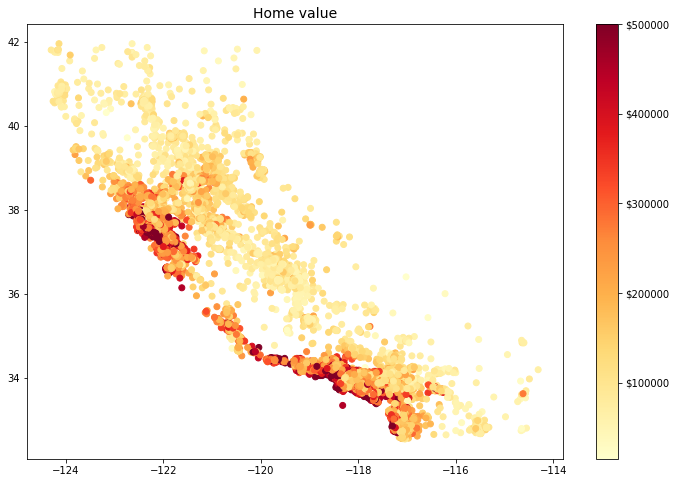

In [207]:
#plt.contour(train_housing["longitude"],train_housing["latitude"], train_housing["median_house_value"])


gridsize = (1, 1)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_title(
    'Home value',
    fontsize=14
)
sctr = ax1.scatter(x=train_housingX["longitude"], y=train_housingX["latitude"], c=train_housingY["median_house_value"], cmap='YlOrRd')
plt.colorbar(sctr, ax=ax1, format='$%d')

4) Препроцессинг

In [208]:
scalerX = StandardScaler()
scalerY = StandardScaler()
train_housingX = scalerX.fit_transform(train_housingX)
train_housingY = scalerY.fit_transform(train_housingY)
test_housingX = scalerX.transform(test_housingX)
test_housingY = scalerY.transform(test_housingY)
validation_housingX = scalerX.transform(validation_housingX)
validation_housingY = scalerY.transform(validation_housingY)
train_housingX = torch.from_numpy(train_housingX).float()
train_housingY = torch.from_numpy(train_housingY).float()
test_housingX = torch.from_numpy(test_housingX).float()
test_housingY = torch.from_numpy(test_housingY).float()
validation_housingX = torch.from_numpy(validation_housingX).float()
validation_housingY = torch.from_numpy(validation_housingY).float()

5) Построение модели


In [238]:
modelWithRelu = torch.nn.Sequential(
        torch.nn.Linear(8, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 30),
        torch.nn.ReLU(),
        torch.nn.Linear(30, 1)
        )
modelWithSigm = torch.nn.Sequential(
        torch.nn.Linear(8, 50),
        torch.nn.Sigmoid(),
        torch.nn.Linear(50, 30),
        torch.nn.Sigmoid(),
        torch.nn.Linear(30, 1)
        )
modelWithTanh = torch.nn.Sequential(
        torch.nn.Linear(8, 50),
        torch.nn.Tanh(),
        torch.nn.Linear(50, 30),
        torch.nn.Tanh(),
        torch.nn.Linear(30, 1)
        )

In [239]:
if torch.cuda.is_available():
  print("Cuda!")
  modelWithRelu = modelWithRelu.cuda()
  modelWithSigm = modelWithSigm.cuda()
  modelWithTanh = modelWithTanh.cuda()
  train_housingX, train_housingY = train_housingX.cuda(), train_housingY.cuda()
  test_housingX, test_housingY = test_housingX.cuda(), test_housingY.cuda()
  validation_housingX, validation_housingY = validation_housingX.cuda(), validation_housingY.cuda()

Cuda!


In [240]:
def train(model, epoch = 5000):
  criterion = torch.nn.MSELoss(reduction='sum')
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  batch_size = 3000 #find experementaly
  history = {'epoch' : [], "loss" : []}
  for epoch in range(epoch):#find experementaly
    order = np.random.permutation(len(train_housingX))
    for startIndex in range(0, len(train_housingX), batch_size):
      optimizer.zero_grad()
      batch_indexes = order[startIndex:startIndex+batch_size]
      x_batch = train_housingX[batch_indexes]
      y_batch = train_housingY[batch_indexes]
      output = model(train_housingX)
      loss = criterion(output, train_housingY)
      loss.backward()
      optimizer.step()
    if (epoch % 100 == 0):
      test_preds = model(test_housingX)
      test_loss = criterion(test_preds, test_housingY)
      history['epoch'].append(epoch)
      history['loss'].append(test_loss.item())
      print('Epoch: ', epoch,'test loss:', test_loss.item())  
  return history

In [241]:
historyReLu = train(modelWithRelu, 1500)
historySigma = train(modelWithSigm,5000)
historyTanh = train(modelWithTanh,2500)

Epoch:  0 test loss: 2548.185546875
Epoch:  100 test loss: 944.48583984375
Epoch:  200 test loss: 732.3516235351562
Epoch:  300 test loss: 661.3922119140625
Epoch:  400 test loss: 617.4777221679688
Epoch:  500 test loss: 582.306640625
Epoch:  600 test loss: 555.58544921875
Epoch:  700 test loss: 538.8746948242188
Epoch:  800 test loss: 530.8615112304688
Epoch:  900 test loss: 522.3427124023438
Epoch:  1000 test loss: 514.3377685546875
Epoch:  1100 test loss: 509.05462646484375
Epoch:  1200 test loss: 507.21630859375
Epoch:  1300 test loss: 507.1709899902344
Epoch:  1400 test loss: 507.8831787109375
Epoch:  0 test loss: 2542.784423828125
Epoch:  100 test loss: 1831.4664306640625
Epoch:  200 test loss: 976.1907348632812
Epoch:  300 test loss: 865.3184814453125
Epoch:  400 test loss: 823.470947265625
Epoch:  500 test loss: 797.955078125
Epoch:  600 test loss: 778.3694458007812
Epoch:  700 test loss: 759.8394165039062
Epoch:  800 test loss: 741.0362548828125
Epoch:  900 test loss: 722.3726

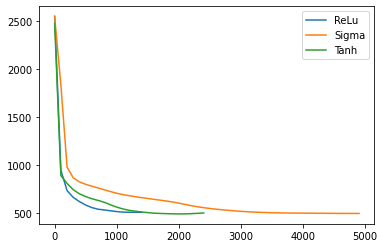

In [242]:
plt.plot(historyReLu['epoch'], historyReLu['loss'], label="ReLu")
plt.plot(historySigma['epoch'], historySigma['loss'], label="Sigma")
plt.plot(historyTanh['epoch'], historyTanh['loss'], label="Tanh")
plt.legend()

In [243]:
def getLosFromModel(model):
  criterion = torch.nn.MSELoss(reduction='sum')
  output = model(validation_housingX)
  loss = criterion(output, validation_housingY)
  return loss

In [244]:
print ("Relu valid los - ",  getLosFromModel(modelWithRelu))
print ("Sigma valid los - ",  getLosFromModel(modelWithSigm))
print ("Tanh valid los - ", getLosFromModel(modelWithTanh))

Relu valid los -  tensor(519.8726, device='cuda:0', grad_fn=<MseLossBackward>)
Sigma valid los -  tensor(509.3607, device='cuda:0', grad_fn=<MseLossBackward>)
Tanh valid los -  tensor(522.3566, device='cuda:0', grad_fn=<MseLossBackward>)


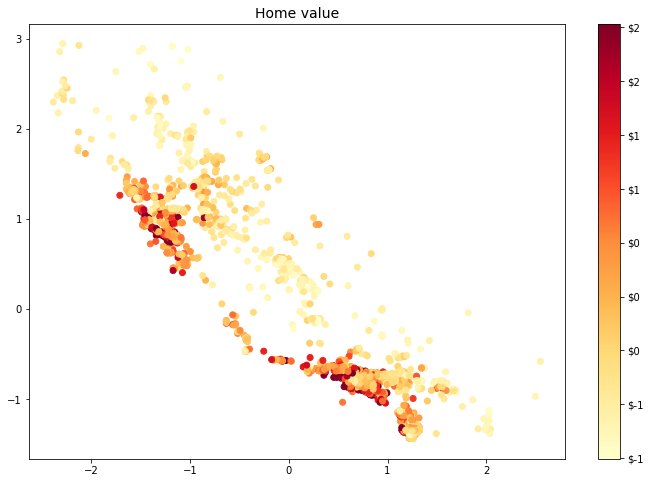

In [245]:
gridsize = (1, 1)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_title(
    'Home value',
    fontsize=14
)
sctr = ax1.scatter(x=validation_housingX.cpu().numpy()[:,0], y=validation_housingX.cpu().numpy()[:,1], c=validation_housingY.cpu().numpy()[:,0], cmap='YlOrRd')
plt.colorbar(sctr, ax=ax1, format='$%d')

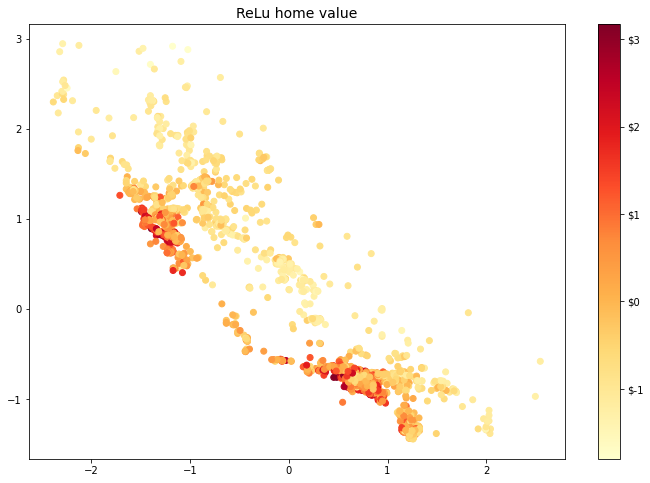

In [246]:
fig = plt.figure(figsize=(12, 8))
ReLuPlot = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=2)
ReLuPlot.set_title(
    'ReLu home value',
    fontsize=14
)
ReLuValues = modelWithRelu(validation_housingX)
relu = ReLuPlot.scatter(x=validation_housingX.cpu().numpy()[:,0], y=validation_housingX.cpu().numpy()[:,1], c=ReLuValues.cpu().detach().numpy()[:,0], cmap='YlOrRd')
plt.colorbar(relu, ax=ReLuPlot, format='$%d')

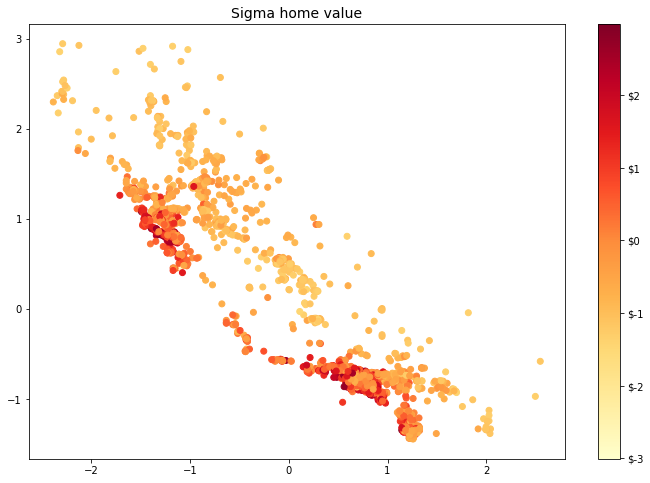

In [247]:
fig = plt.figure(figsize=(12, 8))
SigmaPlot = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=2)
SigmaPlot.set_title(
    'Sigma home value',
    fontsize=14
)
SigmaValues = modelWithSigm(validation_housingX)
sigma = SigmaPlot.scatter(x=validation_housingX.cpu().numpy()[:,0], y=validation_housingX.cpu().numpy()[:,1], c=SigmaValues.cpu().detach().numpy()[:,0], cmap='YlOrRd')
plt.colorbar(sigma, ax=SigmaPlot, format='$%d')

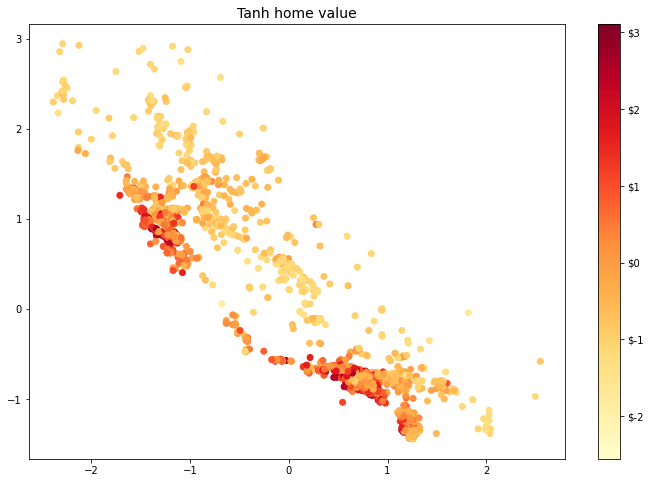

In [248]:
fig = plt.figure(figsize=(12, 8))
TanhPlot = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=2)
TanhPlot.set_title(
    'Tanh home value',
    fontsize=14
)
TanhValues = modelWithTanh(validation_housingX)
sigma = TanhPlot.scatter(x=validation_housingX.cpu().numpy()[:,0], y=validation_housingX.cpu().numpy()[:,1], c=TanhValues.cpu().detach().numpy()[:,0], cmap='YlOrRd')
plt.colorbar(sigma, ax=TanhPlot, format='$%d')

In [91]:
 !pip install pytorch-ignite

     |████████████████████████████████| 184kB 10.8MB/s 


In [249]:
from ignite.contrib.metrics.regression._base import _BaseRegression
from ignite.exceptions import NotComputableError


class R2Score(_BaseRegression):

    def reset(self):
        self._num_examples = 0
        self._sum_of_errors = 0
        self._y_sq_sum = 0
        self._y_sum = 0

    def _update(self, output):
        y_pred, y = output
        self._num_examples += y.shape[0]
        self._sum_of_errors += torch.sum(torch.pow(y_pred - y, 2)).item()

        self._y_sum += torch.sum(y).item()
        self._y_sq_sum += torch.sum(torch.pow(y, 2)).item()

    def compute(self):
        if self._num_examples == 0:
            raise NotComputableError("R2Score must have at least one example before it can be computed.")
        return 1 - self._sum_of_errors / (self._y_sq_sum - (self._y_sum ** 2) / self._num_examples)

In [250]:
r2Core = R2Score()
r2Core._update([validation_housingY, TanhValues])
print("Tanh R2 -", r2Core.compute())
r2Core.reset()
r2Core._update([validation_housingY, SigmaValues])
print("Sigma R2 -", r2Core.compute())
r2Core.reset()
r2Core._update([validation_housingY, ReLuValues])
print("Relu R2 -", r2Core.compute())
r2Core.reset()

Tanh R2 - 0.7563636628148745
Sigma R2 - 0.7569685576895067
Relu R2 - 0.7472527661061594
